# Disease Classification

In this notebook, we will use text classification to automatically classify diseases based on the user's symptoms and feelings.

- **User_input**: user inputs tokenized without preprocessing
- **User_input_preprocessed**: user inputs tokenized with preprocessing
- **User_input_preprocessed_stem**: user inputs tokenized with preprocessing and stemming
- **User_input_preprocessed_lem** : user inputs tokenized with preprocessing and lematization

### Imports

In [5]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import joblib
from nltk.corpus import stopwords
from wordcloud import WordCloud
from hyperopt import hp, fmin, tpe, Trials, space_eval
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Conv1D, GlobalMaxPooling1D, LSTM, Dropout, Bidirectional

#### Run with GPU


In [6]:
#configuration = tf.compat.v1.ConfigProto()
#configuration.gpu_options.allow_growth = True
#session = tf.compat.v1.Session(config=configuration)
#tf.config.list_physical_devices('GPU')

In [7]:
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print('Running on GPU')
    else:
        print("No GPU available, running on CPU")
except Exception as e:
    print("Error:", e)

strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

No GPU available, running on CPU
REPLICAS:  1


In [8]:
MIXED_PRECISION = False
XLA_ACCELERATE = True

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')


Accelerated Linear Algebra enabled


## Data Load

In [9]:
datapath = "Data/dataset.csv"

# Read dataset into a dataframe
data = pd.read_csv(datapath)

# Check loading
print("Data loaded successfully") if data.any(axis=None) else print("Error loading data")

Data loaded successfully


In [10]:
display(data)

,Disease,User_input
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."
...,...,...
10329,Dermatitis,The discomfort in my skin has made it challeng...
10330,Dermatitis,"The raw, sensitive skin from scratching has ma..."
10331,Dermatitis,"I feel like my skin is tearing apart, causing ..."
10332,Dermatitis,Engaging in physical activities has become unb...


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10334 entries, 0 to 10333
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     10334 non-null  object
 1   User_input  10334 non-null  object
dtypes: object(2)
memory usage: 161.6+ KB


In [12]:
print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns." )
print(f"Dataset has {data['Disease'].nunique()} different diseases: {data['Disease'].unique()}.")

Dataset contains 10334 rows and 2 columns.
Dataset has 5 different diseases: ['Psoriasis' 'Melanoma' 'Urticaria' 'Lupus' 'Dermatitis'].


<Axes: title={'center': 'Dataset balancing'}, xlabel='Disease'>

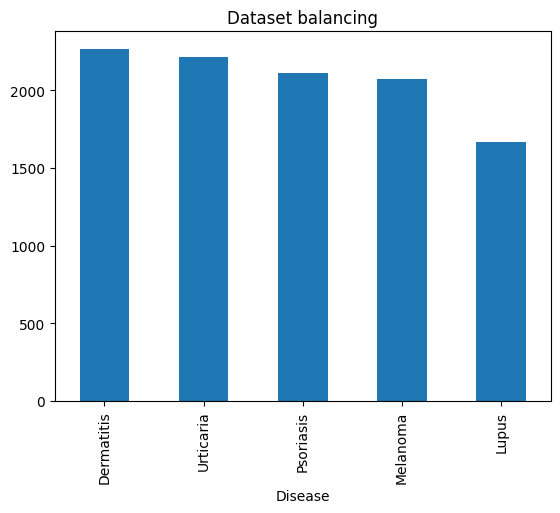

In [13]:
# Plot dataset balancing
data['Disease'].value_counts().plot(kind='bar', title='Dataset balancing')

In [14]:
words = set()

for sentence in data['User_input']:
    for word in sentence.split():
        words.add(word)

num_unique_words = len(words)
print(f"Number of unique words: {num_unique_words}")

Number of unique words: 4631


## Model Evaluation

In [15]:
def evaluate(model, X_train, X_Test, y_train, y_test):
    # Train
    y_train_pred = model.predict(X_train)
    print("\033[1mTraining Results\033[0m")
    print(f"Accuracy Score: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Specificity Score: {recall_score(y_train, y_train_pred, average='weighted', labels=np.unique(y_test)):.4f}")
    print(f"Precision Score: {precision_score(y_train, y_train_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_train, y_train_pred, average='weighted'):.4f}")

    # Test
    y_test_pred = model.predict(X_Test)
    print("\n\033[1mTesting Results\033[0m")
    print(f"Accuracy Score: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Specificity Score: {recall_score(y_test, y_test_pred, average='weighted', labels=np.unique(y_test)):.4f}")
    print(f"Precision Score: {precision_score(y_test, y_test_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")
    
    # Classification report train
    print("\n\033[1mClassification Report Train\033[0m")
    print(classification_report(y_train, y_train_pred))

    # Classification report test
    print("\n\033[1mClassification Report Test\033[0m")
    print(classification_report(y_test, y_test_pred))

    # Figure for confusion matrix and roc
    fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(15, 5))

    # Confusion matrix
    conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred), display_labels=model.classes_)
    conf_matrix.plot(ax=ax1)

    # Roc Curve for each disease
    prediction = model.predict_proba(X_Test)
    falsepositive, truepositive, thresh = {}, {}, {}
    for i, disease in enumerate(model.classes_):
        falsepositive[disease], truepositive[disease], thresh[disease] = roc_curve(y_test, 
                                                                        prediction[:, i], 
                                                                        pos_label=disease)
    
    ax2.set_title('ROC Curve')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    for disease in model.classes_:
        ax2.plot(falsepositive[disease], truepositive[disease], label=disease)
    
    ax2.plot()

    #return test f1score
    return f1_score(y_test, y_test_pred, average='weighted')


def evaluate_dp(model, history, X, Y):
    print("\n\033[1mTesting Results\033[0m")
    loss, accuracy = model.evaluate(X, Y, verbose=-1)
    print("Loss: ", loss)
    print("Accuracy: ", accuracy)

    figure_dp, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'])
    ax1.plot()

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'])
    ax2.plot()


## Text Preprocessing

In [16]:
data['User_input_preprocessed'] = data['User_input']

- Remove stop words - Stop words are frequently occuring words in a language that are commonly omitted from NLP tasks due to their low significance for deciphering textual meaning.
- Remove pontuations
- Remove words with a single letter
- Transfrom all text in lower case

In [17]:
# Load english stop words using stopwords
# nltk.download('stopwords')

# Remove stop words
stop_words = stopwords.words('english')
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
# Remove words with a sigle letter
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))
# Transform in lower case
data['User_input_preprocessed'] = data['User_input_preprocessed'].str.lower()
# Remove special chars and pontuation like '.' ','
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
# Remove digits
data['User_input_preprocessed'] = data['User_input_preprocessed'].str.replace('\d+', '')


## Data Visualization

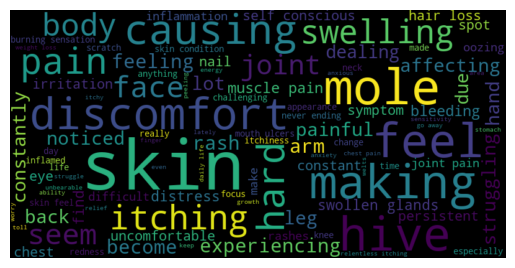

In [18]:
# General word cloud
word_list = " ".join(text for text in data['User_input'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Psoriasis

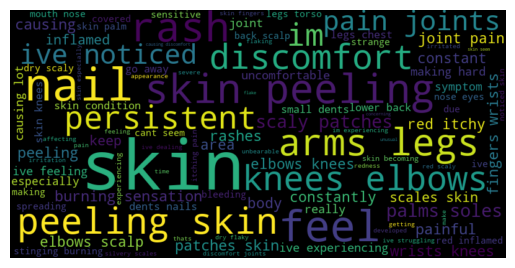

In [19]:
psoriasis = data[data['Disease'] == 'Psoriasis']

word_list = " ".join(text for text in psoriasis['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Melanoma

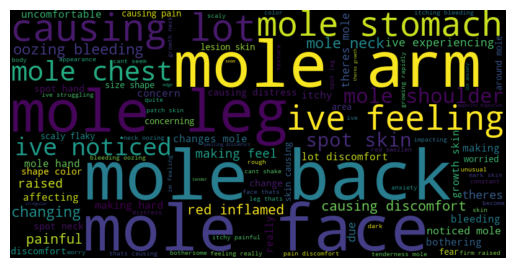

In [20]:
melanoma = data[data['Disease'] == 'Melanoma']

word_list = " ".join(text for text in melanoma['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Urticaria

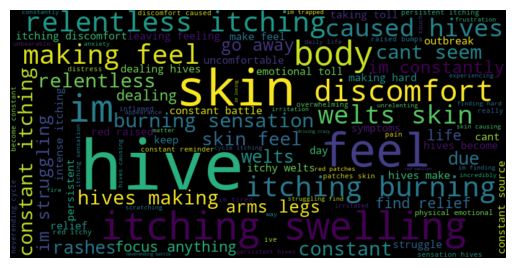

In [21]:
urticaria = data[data['Disease'] == 'Urticaria']

word_list = " ".join(text for text in urticaria['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Lupus

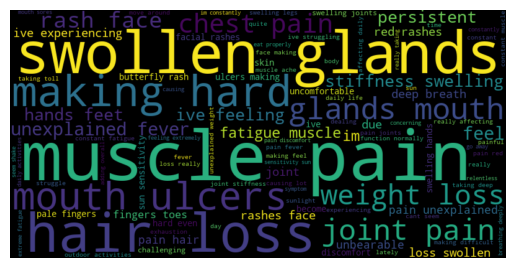

In [22]:
lupus = data[data['Disease'] == 'Lupus']

word_list = " ".join(text for text in lupus['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Dermatitis

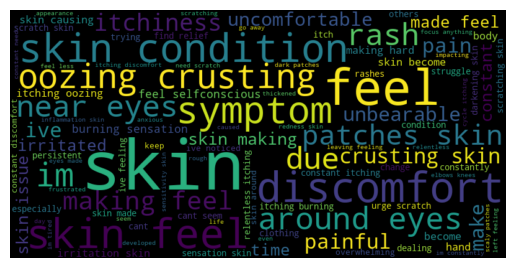

In [23]:
dermatitis = data[data['Disease'] == 'Dermatitis']

word_list = " ".join(text for text in dermatitis['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Tokenization

In [24]:
# Tokenization by white space
#tokenizer = nltk.tokenize.WhitespaceTokenizer()
#data['User_input_token_whitespace'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))

# Tokenization by tree bank
#tokenizer = nltk.tokenize.TreebankWordDetokenizer()
#data['User_input_token_treebank'] = data['User_input_token_whitespace'].apply(lambda x: tokenizer.detokenize(x))

# Tokenization by word punct
#tokenizer = nltk.tokenize.WordPunctTokenizer()
#data['User_input_token_wordpunct'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))


## Stemming & Lamitization

### Stemming
Stemming is the process of reducing words to their word stems or roots by removing suffixes or prefixes. It uses simple rules to chop off ends of words, potentially resulting in non-real words.

### Lemmatization
Lemmatization, on the other hand, involves reducing words to their base or canonical form, known as the lemma, by considering the morphological analysis of the word. This process involves dictionary lookup to find the lemma, making it more accurate but potentially slower than stemming.

In [25]:
#nltk.download('wordnet')

In [26]:
tokenizer = nltk.tokenize.WhitespaceTokenizer()
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))
data['User_input'] = data['User_input'].apply(lambda x: tokenizer.tokenize(x))

In [27]:
# Stemming
stemmer = nltk.stem.PorterStemmer()
data['User_input_preprocessed_stem'] = data['User_input_preprocessed'].apply(lambda x: [stemmer.stem(word) for word in x])

In [28]:
# Lemmatization
lemmatizer = nltk.stem.WordNetLemmatizer()
data['User_input_preprocessed_lem'] = data['User_input_preprocessed'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [29]:
display(data)

,Disease,User_input,User_input_preprocessed,User_input_preprocessed_stem,User_input_preprocessed_lem
0,Psoriasis,"[I, have, been, experiencing, a, skin, rash, o...","[experiencing, skin, rash, arms, legs, torso, ...","[experienc, skin, rash, arm, leg, torso, past,...","[experiencing, skin, rash, arm, leg, torso, pa..."
1,Psoriasis,"[My, skin, has, been, peeling,, especially, on...","[my, skin, peeling, especially, knees, elbows,...","[my, skin, peel, especi, knee, elbow, scalp, t...","[my, skin, peeling, especially, knee, elbow, s..."
2,Psoriasis,"[I, have, been, experiencing, joint, pain, in,...","[experiencing, joint, pain, fingers, wrists, k...","[experienc, joint, pain, finger, wrist, knee, ...","[experiencing, joint, pain, finger, wrist, kne..."
3,Psoriasis,"[There, is, a, silver, like, dusting, on, my, ...","[there, silver, like, dusting, skin, especiall...","[there, silver, like, dust, skin, especi, lowe...","[there, silver, like, dusting, skin, especiall..."
4,Psoriasis,"[My, nails, have, small, dents, or, pits, in, ...","[my, nails, small, dents, pits, them, often, f...","[my, nail, small, dent, pit, them, often, feel...","[my, nail, small, dent, pit, them, often, feel..."
...,...,...,...,...,...
10329,Dermatitis,"[The, discomfort, in, my, skin, has, made, it,...","[the, discomfort, skin, made, challenging, par...","[the, discomfort, skin, made, challeng, partak...","[the, discomfort, skin, made, challenging, par..."
10330,Dermatitis,"[The, raw,, sensitive, skin, from, scratching,...","[the, raw, sensitive, skin, scratching, made, ...","[the, raw, sensit, skin, scratch, made, unbear...","[the, raw, sensitive, skin, scratching, made, ..."
10331,Dermatitis,"[I, feel, like, my, skin, is, tearing, apart,,...","[feel, like, skin, tearing, apart, causing, ex...","[feel, like, skin, tear, apart, caus, excruci,...","[feel, like, skin, tearing, apart, causing, ex..."
10332,Dermatitis,"[Engaging, in, physical, activities, has, beco...","[engaging, physical, activities, become, unbea...","[engag, physic, activ, becom, unbear, due, sen...","[engaging, physical, activity, become, unbeara..."


## Embeddings

### Bag of Words (BoW)
Is a technique in NLP that represents text as a frequency count of words in a corpus, creating a numerical vector representing the corpus

In [30]:
boW = CountVectorizer(stop_words='english')

bow_normal = boW.fit(data['User_input'].apply(' '.join))

bow_preprocessed = boW.fit(data["User_input_preprocessed"].apply(' '.join))

bow_lem = boW.fit(data['User_input_preprocessed_lem'].apply(' '.join))

bow_stem = boW.fit(data['User_input_preprocessed_stem'].apply(' '.join))


We think that to understand the symptoms is important to use n-grams

In [31]:
bow_ngram = CountVectorizer(stop_words='english', ngram_range=(4,4))

bow_ngram_normal = bow_ngram.fit(data['User_input'].apply(' '.join))

bow_ngram_preprocessed = bow_ngram.fit(data["User_input_preprocessed"].apply(' '.join))

bow_ngram_lem = bow_ngram.fit(data['User_input_preprocessed_lem'].apply(' '.join))

bow_ngram_stem = bow_ngram.fit(data['User_input_preprocessed_stem'].apply(' '.join))


### TF-IDF

In [32]:
tf_idf = TfidfVectorizer()

tf_idf_normal = tf_idf.fit(data['User_input'].apply(' '.join))

tf_idf_preprocessed = tf_idf.fit(data['User_input_preprocessed'].apply(' '.join))

tf_idf_lem = tf_idf.fit(data['User_input_preprocessed_lem'].apply(' '.join))

tf_idf_stem = tf_idf.fit(data['User_input_preprocessed_stem'].apply(' '.join))


In [33]:
#Smoothing to avoid 0 probabilities
#data_tfidf = data_tfidf + 1

# Normalize
#data_tfidf = data_tfidf.div(data_tfidf.sum(axis=1), axis=0)

#display(data_tfidf)

## Data spliting

Once the dataset was created by the group, we decided to create a balanced dataset to make the next steps easier.

In [34]:
# Split dataset into training and testing sets
# Create a test and a train dataframe
train, test = train_test_split(data, test_size=0.2, random_state=42)

# Check splitting
print(f"Train dataset contains {train.shape[0]} rows and {train.shape[1]} columns.")
print(f"Test dataset contains {test.shape[0]} rows and {test.shape[1]} columns.")

Train dataset contains 8267 rows and 5 columns.
Test dataset contains 2067 rows and 5 columns.


In [35]:
display(train)

,Disease,User_input,User_input_preprocessed,User_input_preprocessed_stem,User_input_preprocessed_lem
4880,Urticaria,"[I'm, struggling, to, find, moments, of, peace...","[im, struggling, find, moments, peace, amidst,...","[im, struggl, find, moment, peac, amidst, chao...","[im, struggling, find, moment, peace, amidst, ..."
6651,Lupus,"[My, sensitivity, to, sunlight, is, causing, m...","[my, sensitivity, sunlight, causing, lot, disc...","[my, sensit, sunlight, caus, lot, discomfort, ...","[my, sensitivity, sunlight, causing, lot, disc..."
6451,Urticaria,"[The, hives, have, disrupted, every, aspect, o...","[the, hives, disrupted, every, aspect, life, w...","[the, hive, disrupt, everi, aspect, life, work...","[the, hive, disrupted, every, aspect, life, wo..."
4157,Melanoma,"[I've, recently, noticed, this, growth, on, my...","[ive, recently, noticed, growth, leg, causing,...","[ive, recent, notic, growth, leg, caus, lot, t...","[ive, recently, noticed, growth, leg, causing,..."
828,Psoriasis,"[I, struggle, with, painful, swelling, in, my,...","[struggle, painful, swelling, joints, daily]","[struggl, pain, swell, joint, daili]","[struggle, painful, swelling, joint, daily]"
...,...,...,...,...,...
5734,Urticaria,"[The, hives, on, my, skin, have, caused, such,...","[the, hives, skin, caused, intense, itching, s...","[the, hive, skin, caus, intens, itch, swell, l...","[the, hive, skin, caused, intense, itching, sw..."
5191,Urticaria,"[The, itching, and, swelling, have, become, a,...","[the, itching, swelling, become, constant, sou...","[the, itch, swell, becom, constant, sourc, str...","[the, itching, swelling, become, constant, sou..."
5390,Urticaria,"[It, feels, like, I'm, living, in, a, body, th...","[it, feels, like, im, living, body, thats, hij...","[it, feel, like, im, live, bodi, that, hijack,...","[it, feel, like, im, living, body, thats, hija..."
860,Psoriasis,"[I'm, frustrated, by, the, visible, scales, th...","[im, frustrated, visible, scales, formed, body]","[im, frustrat, visibl, scale, form, bodi]","[im, frustrated, visible, scale, formed, body]"


#### Define X

##### BoW

In [36]:
# without preprocessing
X_train_bow_noproc = bow_normal.transform(train['User_input'].apply(' '.join))
X_test_bow_noproc = bow_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_bow_proc = bow_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_bow_proc = bow_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_bow_stem = bow_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_bow_stem = bow_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_bow_lem = bow_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_bow_lem = bow_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))

##### Ngram

In [37]:
# without preprocessing
X_train_ngram_noproc = bow_ngram_normal.transform(train['User_input'].apply(' '.join))
X_test_ngram_noproc = bow_ngram_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_ngram_proc = bow_ngram_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_ngram_proc = bow_ngram_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_ngram_stem = bow_ngram_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_ngram_stem = bow_ngram_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_ngram_lem = bow_ngram_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_ngram_lem = bow_ngram_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))


##### TF-IDF

In [38]:
# without preprocessing
X_train_tfidf_noproc = tf_idf_normal.transform(train['User_input'].apply(' '.join))
X_test_tfidf_noproc = tf_idf_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_tfidf_proc = tf_idf_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_tfidf_proc = tf_idf_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_tfidf_stem = tf_idf_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_tfidf_stem = tf_idf_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_tfidf_lem = tf_idf_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_tfidf_lem = tf_idf_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))

#### Define Y

In [39]:
y_train = train['Disease']
y_test = test['Disease']

## Text classification

### Machine Learning

#### Logistic Regression

**Important Parameters:**
- Solver
- Penalty
- C
- Max_Iter

In [40]:
best_score_lr = 0
best_modeltype_lr = ""
best_model = None

##### Hyperopt

In [41]:
def hyperopt_lr(X_train):
    space = {
        'solver': hp.choice('solver', ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']),
        'penalty': hp.choice('penalty', ['l2']),
        'C': hp.uniform('C', 1.0, 10.0),
        'max_iter': hp.choice('max_iter', [1, 2, 5, 10, 20, 50, 100, 200, 500])
    }

    def objective(params):
        clf = LogisticRegression(solver=params['solver'], penalty=params['penalty'], C=params['C'],
                                 max_iter=params['max_iter'])
        score = cross_val_score(clf, X_train, y_train, cv=5).mean()
        return -score

    tpe_algorithm = tpe.suggest

    trials = Trials()

    best = fmin(fn=objective,
                space=space,
                algo=tpe_algorithm,
                max_evals=50,
                trials=trials)

    best_params = space_eval(space, best)
    print("Best hyperparameters:", best_params)
    return best_params


##### Grid Search

In [42]:
def grid_search_lr(X_train):
    lr = LogisticRegression()

    param_grid = [
        {
            'solver': ['liblinear'],
            'penalty': ['l1','l2'],
            'C': np.arange(1.0, 10.0, 1.0),
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['lbfgs','newton-cg','sag'],
            'penalty': ['l2',],
            'C': np.arange(1.0, 10.0, 1.0),
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['saga'],
            'penalty': ['l1','l2'],
            'C': np.arange(1.0, 10.0, 1.0),
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['saga'],
            'penalty': ['elasticnet'],
            'C': np.arange(1.0, 10.0, 1.0),
            'l1_ratio': [0.1, 0.5, 0.9],  # Add l1_ratio here
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['saga', 'sag', 'newton-cg', 'lbfgs'],
            'penalty': [None],
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        }
    ]

    grid = GridSearchCV(estimator=lr, param_grid=param_grid, verbose=0, n_jobs=-1, cv=2, scoring='accuracy')
    grid.fit(X_train, y_train)

    print(f"Best parameters: {grid.best_params_}")
    return grid.best_params_


##### Run Model

In [43]:
def model_lr(best_param, X_train, X_test, model_type):
    global best_score_lr, best_modeltype_lr, best_model
    
    lr = LogisticRegression(solver=best_param['solver'], penalty=best_param['penalty'], C=best_param['C'], max_iter=best_param['max_iter'])
    lr.fit(X_train, y_train)
    score = evaluate(lr, X_train, X_test, y_train, y_test)
    
    if score > best_score_lr:
        best_score_lr = score
        best_modeltype_lr = model_type
        best_model = lr

##### Without Preprocessing

In [44]:
name = "LR_withoutyproc_"

**BoW** 

100%|██████████| 50/50 [00:09<00:00,  5.38trial/s, best loss: -0.7324291109711484]
Best hyperparameters: {'C': 2.910220491126923, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Training Results
Accuracy Score: 0.7795
Specificity Score: 0.7795
Precision Score: 0.7860
F1 Score: 0.7785

Testing Results
Accuracy Score: 0.7146
Specificity Score: 0.7146
Precision Score: 0.7214
F1 Score: 0.7140

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.65      0.71      0.68      1803
       Lupus       0.88      0.88      0.88      1355
    Melanoma       0.99      0.99      0.99      1677
   Psoriasis       0.77      0.57      0.65      1668
   Urticaria       0.67      0.77      0.72      1764

    accuracy                           0.78      8267
   macro avg       0.79      0.78      0.78      8267
weighted avg       0.79      0.78      0.78      8267


Classification Report Test
              precision    recall  f1-score   support

  

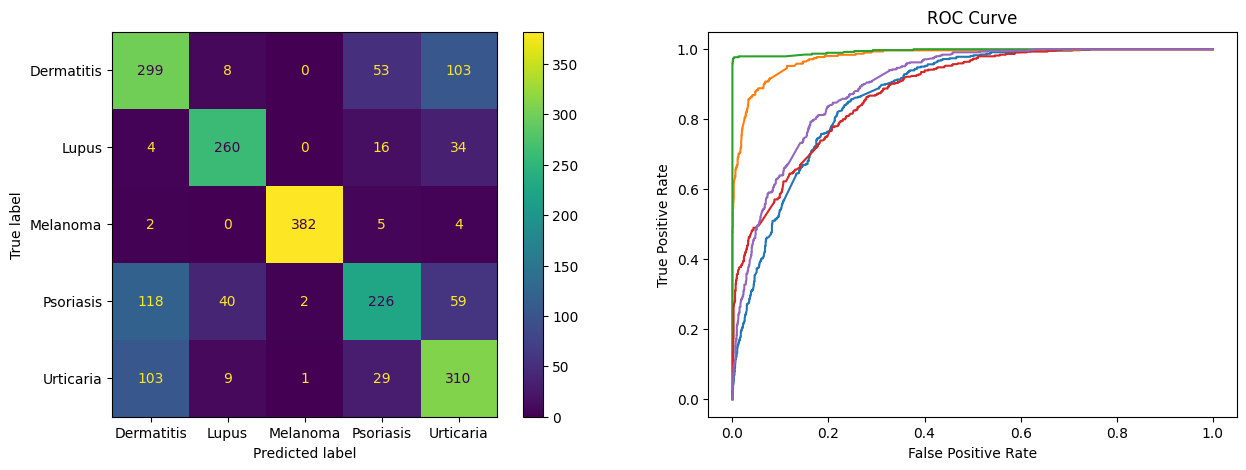

In [45]:
best_params = hyperopt_lr(X_train_bow_noproc)
model_lr(best_params, X_train_bow_noproc, X_test_bow_noproc , name + "bow")

Best parameters: {'C': 4.0, 'max_iter': 50, 'penalty': 'l2', 'solver': 'lbfgs'}
Training Results
Accuracy Score: 0.7744
Specificity Score: 0.7744
Precision Score: 0.7749
F1 Score: 0.7739

Testing Results
Accuracy Score: 0.7121
Specificity Score: 0.7121
Precision Score: 0.7126
F1 Score: 0.7117

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.68      0.62      0.65      1803
       Lupus       0.87      0.88      0.88      1355
    Melanoma       0.99      0.98      0.99      1677
   Psoriasis       0.68      0.67      0.67      1668
   Urticaria       0.68      0.75      0.71      1764

    accuracy                           0.77      8267
   macro avg       0.78      0.78      0.78      8267
weighted avg       0.77      0.77      0.77      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.58      0.56      0.57       463
       Lupus       0.82      0.84      0.83       3

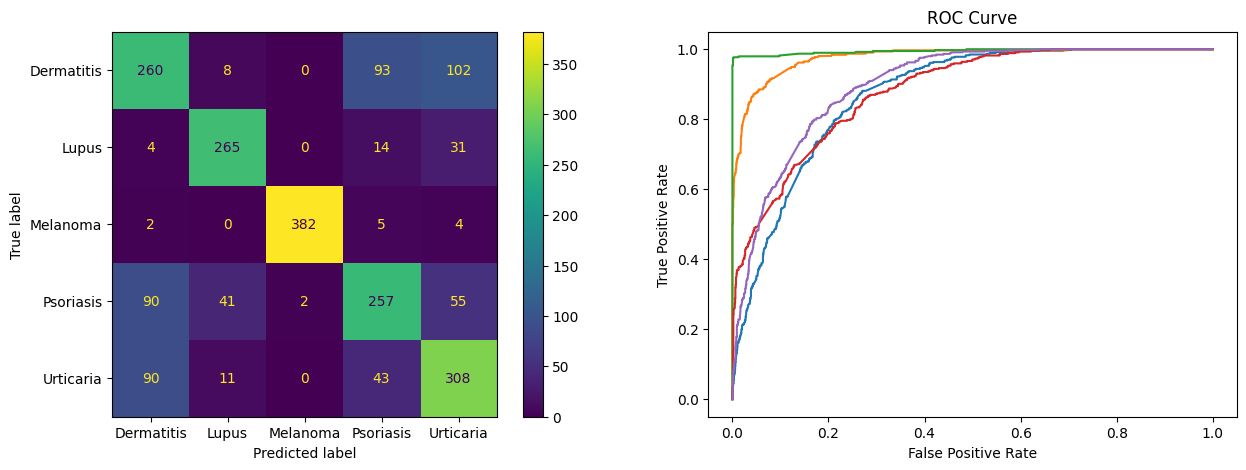

In [46]:
best_params = grid_search_lr(X_train_bow_noproc)
model_lr(best_params, X_train_bow_noproc, X_test_bow_noproc, name + "bow")

**n-grams**

100%|██████████| 50/50 [00:26<00:00,  1.92trial/s, best loss: -0.2368450313123843] 
Best hyperparameters: {'C': 1.8458197658783946, 'max_iter': 10, 'penalty': 'l2', 'solver': 'sag'}
Training Results
Accuracy Score: 0.2574
Specificity Score: 0.2574
Precision Score: 0.7943
F1 Score: 0.1562

Testing Results
Accuracy Score: 0.2419
Specificity Score: 0.2419
Precision Score: 0.7020
F1 Score: 0.1196

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.23      1.00      0.37      1803
       Lupus       1.00      0.09      0.17      1355
    Melanoma       1.00      0.05      0.10      1677
   Psoriasis       0.88      0.03      0.06      1668
   Urticaria       0.94      0.04      0.07      1764

    accuracy                           0.26      8267
   macro avg       0.81      0.24      0.15      8267
weighted avg       0.79      0.26      0.16      8267


Classification Report Test
              precision    recall  f1-score   support

  D

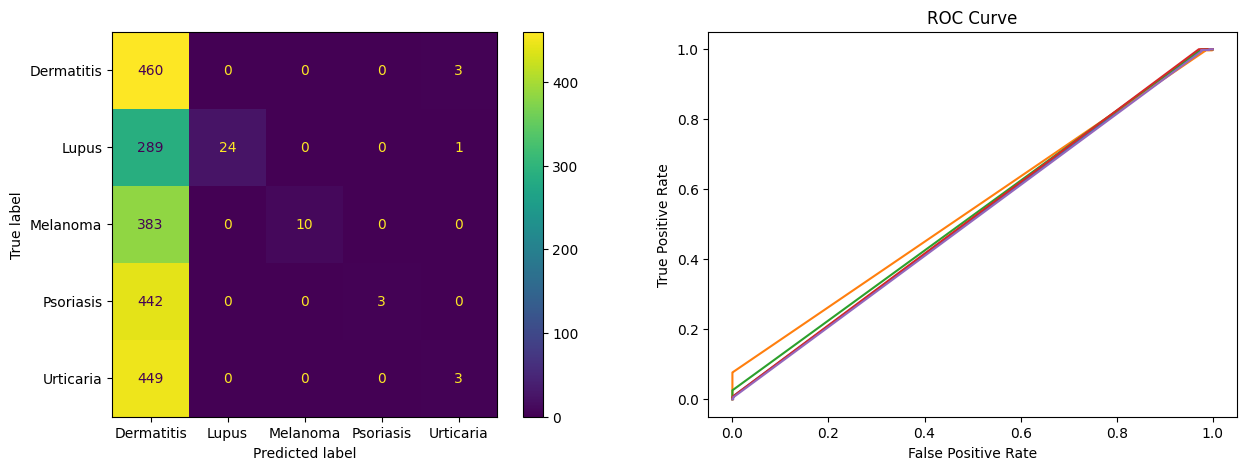

In [47]:
best_params = hyperopt_lr(X_train_ngram_noproc)
model_lr(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "ngram")

Best parameters: {'C': 6.0, 'max_iter': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.2575
Specificity Score: 0.2575
Precision Score: 0.8017
F1 Score: 0.1562

Testing Results
Accuracy Score: 0.2414
Specificity Score: 0.2414
Precision Score: 0.7020
F1 Score: 0.1187

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.23      1.00      0.37      1803
       Lupus       1.00      0.09      0.17      1355
    Melanoma       1.00      0.05      0.10      1677
   Psoriasis       0.92      0.03      0.06      1668
   Urticaria       0.93      0.04      0.08      1764

    accuracy                           0.26      8267
   macro avg       0.82      0.24      0.15      8267
weighted avg       0.80      0.26      0.16      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.23      0.99      0.37       463
       Lupus       1.00      0.08      0.14     

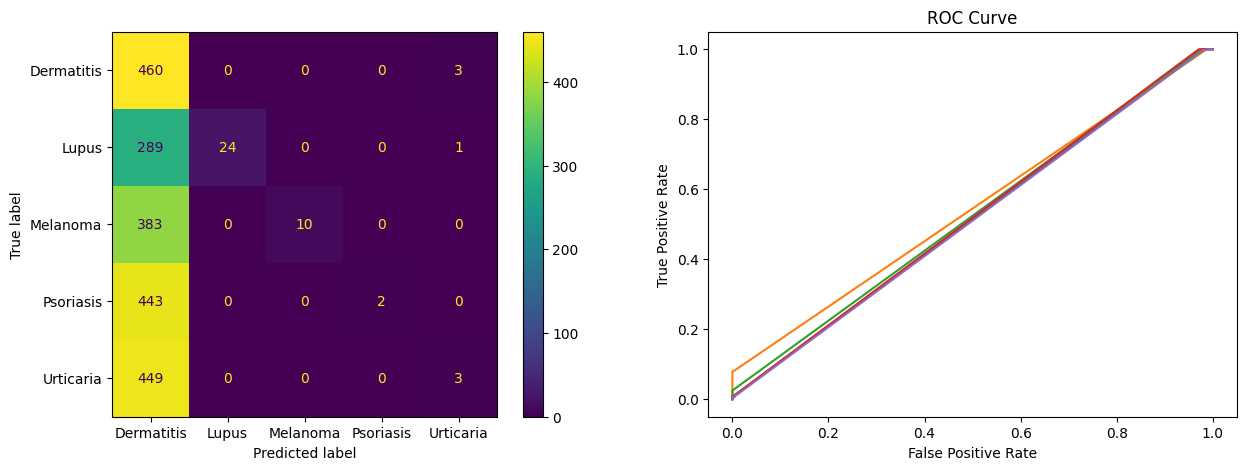

In [48]:
best_params = grid_search_lr(X_train_ngram_noproc)
model_lr(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "ngram")

**TF-IDF**

100%|██████████| 50/50 [00:26<00:00,  1.89trial/s, best loss: -0.7838376744931168]
Best hyperparameters: {'C': 8.199503803137675, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Training Results
Accuracy Score: 0.8322
Specificity Score: 0.8322
Precision Score: 0.8338
F1 Score: 0.8319

Testing Results
Accuracy Score: 0.7639
Specificity Score: 0.7639
Precision Score: 0.7680
F1 Score: 0.7647

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.72      0.78      0.75      1803
       Lupus       0.89      0.90      0.90      1355
    Melanoma       1.00      0.99      0.99      1677
   Psoriasis       0.80      0.69      0.74      1668
   Urticaria       0.79      0.82      0.80      1764

    accuracy                           0.83      8267
   macro avg       0.84      0.84      0.84      8267
weighted avg       0.83      0.83      0.83      8267


Classification Report Test
              precision    recall  f1-score   support

  

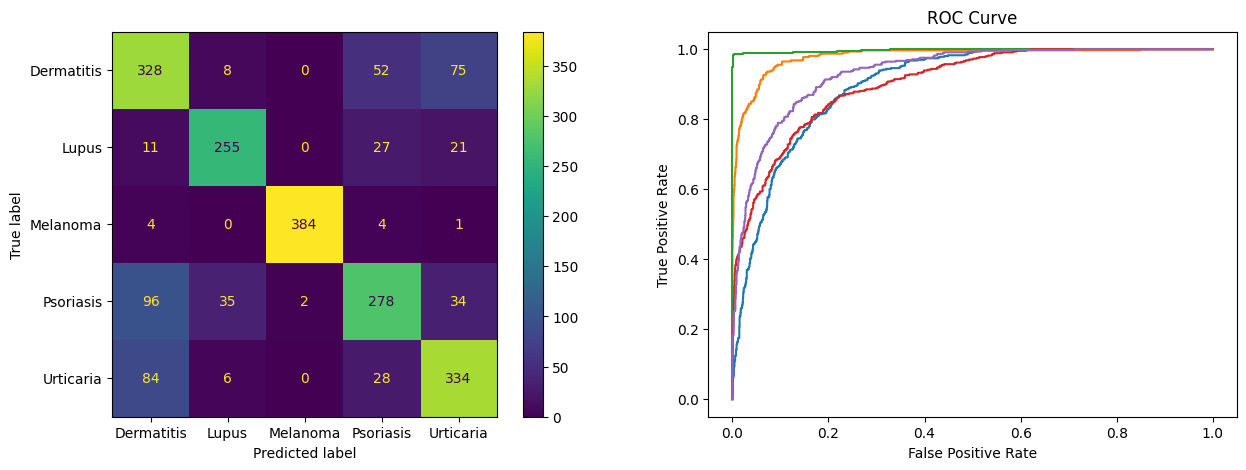

In [49]:
best_params = hyperopt_lr(X_train_tfidf_noproc)
model_lr(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

Best parameters: {'C': 5.0, 'max_iter': 5, 'penalty': 'l1', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.8305
Specificity Score: 0.8305
Precision Score: 0.8335
F1 Score: 0.8304

Testing Results
Accuracy Score: 0.7605
Specificity Score: 0.7605
Precision Score: 0.7659
F1 Score: 0.7610

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.71      0.78      0.74      1803
       Lupus       0.90      0.89      0.90      1355
    Melanoma       0.99      0.99      0.99      1677
   Psoriasis       0.81      0.68      0.74      1668
   Urticaria       0.78      0.82      0.80      1764

    accuracy                           0.83      8267
   macro avg       0.84      0.83      0.83      8267
weighted avg       0.83      0.83      0.83      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.61      0.70      0.65       463
       Lupus       0.85      0.82      0.83     

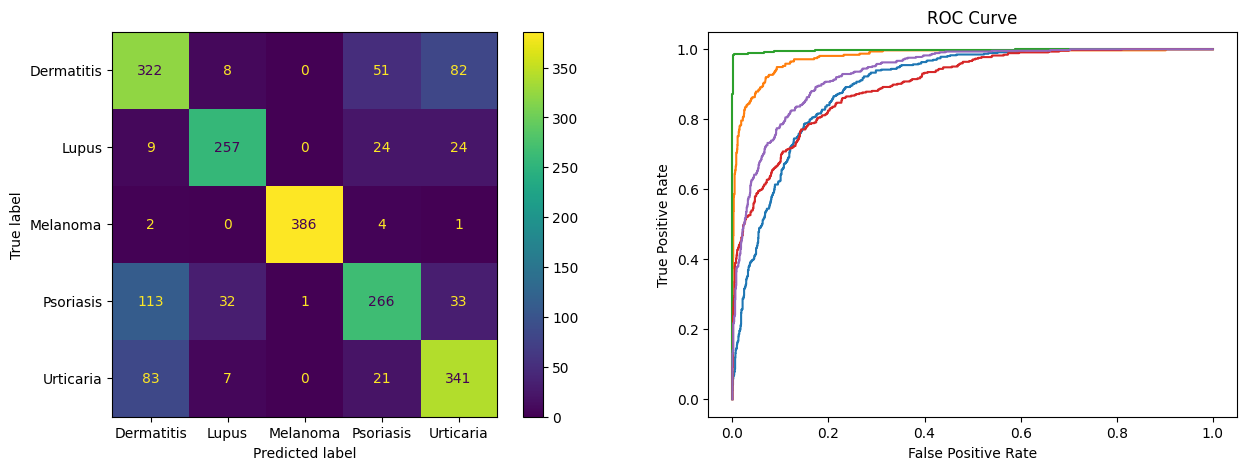

In [51]:
best_params = grid_search_lr(X_train_tfidf_noproc)
model_lr(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

##### With Preprocessing

In [52]:
name = "LR_withproc_"

**BoW** 

100%|██████████| 50/50 [00:18<00:00,  2.67trial/s, best loss: -0.7365419657637611]
Best hyperparameters: {'C': 3.889583716285016, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.7796
Specificity Score: 0.7796
Precision Score: 0.7832
F1 Score: 0.7789

Testing Results
Accuracy Score: 0.7150
Specificity Score: 0.7150
Precision Score: 0.7188
F1 Score: 0.7143

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.66      0.69      0.68      1803
       Lupus       0.88      0.87      0.87      1355
    Melanoma       0.99      0.99      0.99      1677
   Psoriasis       0.74      0.59      0.66      1668
   Urticaria       0.67      0.78      0.72      1764

    accuracy                           0.78      8267
   macro avg       0.79      0.78      0.78      8267
weighted avg       0.78      0.78      0.78      8267


Classification Report Test
              precision    recall  f1-score   support

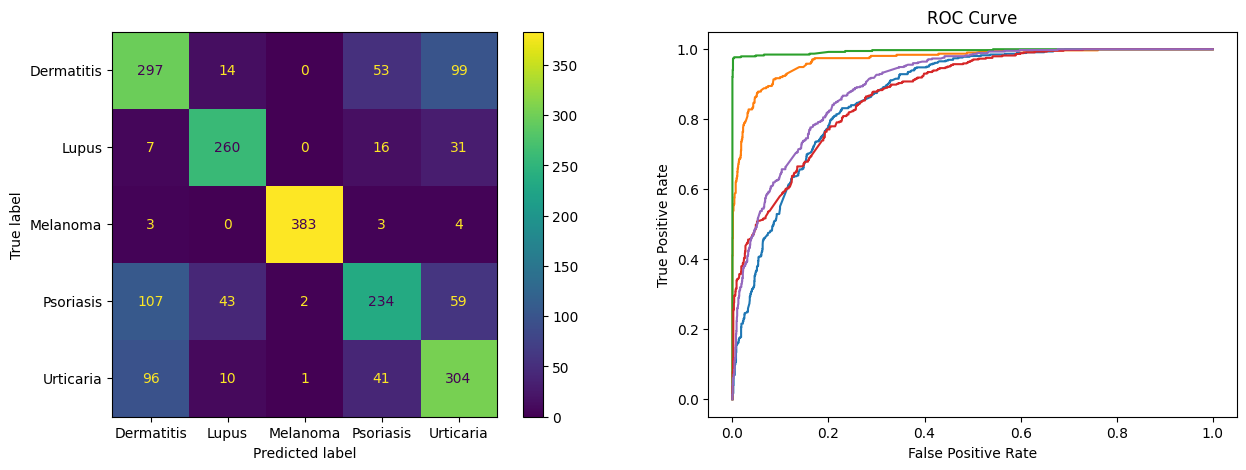

In [53]:
best_params = hyperopt_lr(X_train_bow_proc)
model_lr(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

Best parameters: {'C': 2.0, 'max_iter': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Training Results
Accuracy Score: 0.7812
Specificity Score: 0.7812
Precision Score: 0.7841
F1 Score: 0.7806

Testing Results
Accuracy Score: 0.7170
Specificity Score: 0.7170
Precision Score: 0.7204
F1 Score: 0.7161

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.66      0.69      0.68      1803
       Lupus       0.88      0.88      0.88      1355
    Melanoma       0.99      0.99      0.99      1677
   Psoriasis       0.73      0.60      0.66      1668
   Urticaria       0.68      0.77      0.72      1764

    accuracy                           0.78      8267
   macro avg       0.79      0.79      0.79      8267
weighted avg       0.78      0.78      0.78      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.58      0.64      0.61       463
       Lupus       0.79      0.84      0.82    

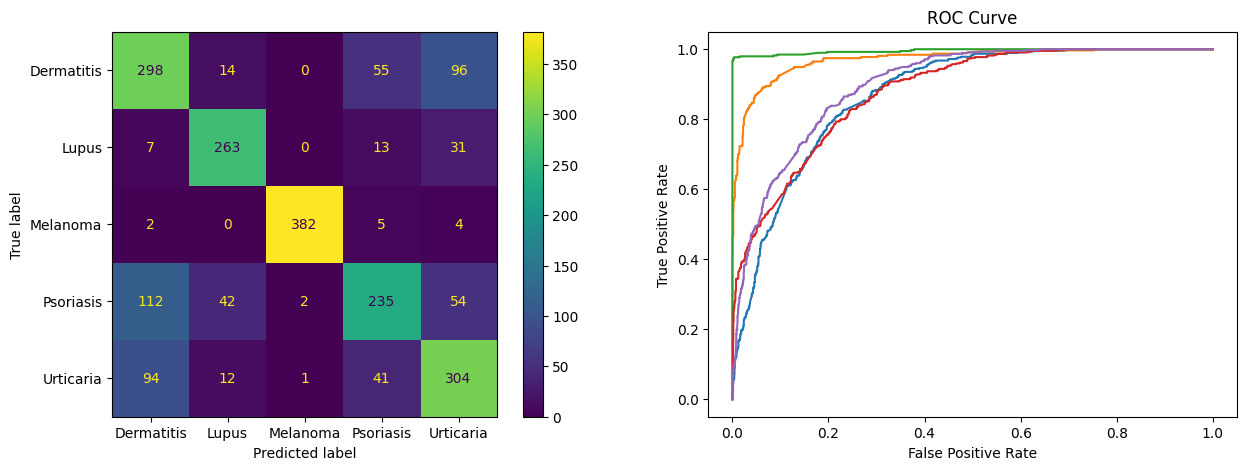

In [54]:
best_params = grid_search_lr(X_train_bow_proc)
model_lr(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

**n-grams**

100%|██████████| 50/50 [00:30<00:00,  1.66trial/s, best loss: -0.2387802471194874] 
Best hyperparameters: {'C': 7.041484616210381, 'max_iter': 10, 'penalty': 'l2', 'solver': 'sag'}
Training Results
Accuracy Score: 0.2626
Specificity Score: 0.2626
Precision Score: 0.8108
F1 Score: 0.1663

Testing Results
Accuracy Score: 0.2453
Specificity Score: 0.2453
Precision Score: 0.7500
F1 Score: 0.1264

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.23      0.99      0.37      1803
       Lupus       1.00      0.10      0.18      1355
    Melanoma       1.00      0.06      0.11      1677
   Psoriasis       1.00      0.03      0.05      1668
   Urticaria       0.90      0.06      0.11      1764

    accuracy                           0.26      8267
   macro avg       0.83      0.25      0.16      8267
weighted avg       0.81      0.26      0.17      8267


Classification Report Test
              precision    recall  f1-score   support

  De

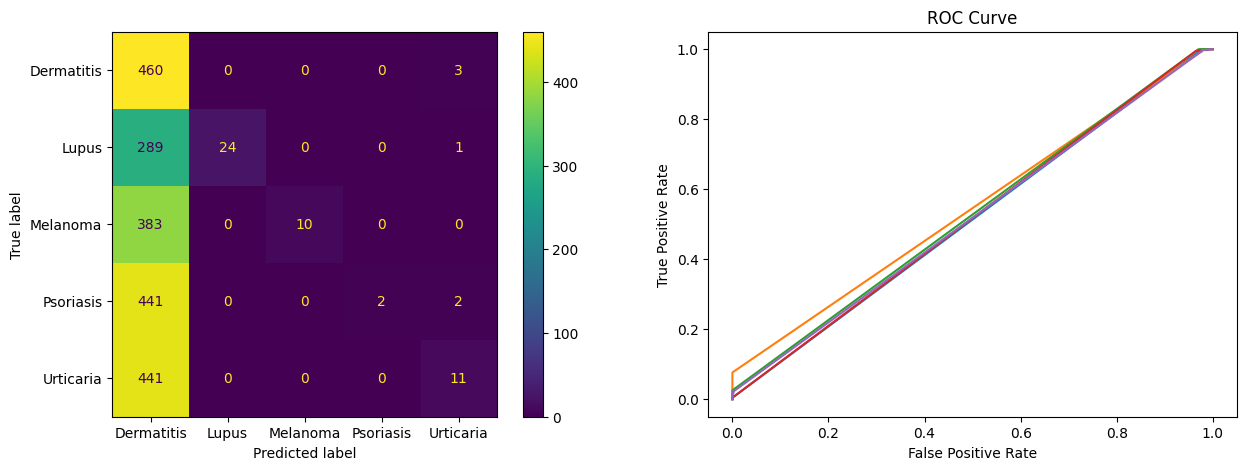

In [55]:
best_params = hyperopt_lr(X_train_ngram_proc)
model_lr(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "ngram")

Best parameters: {'C': 4.0, 'max_iter': 5, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.2626
Specificity Score: 0.2626
Precision Score: 0.8140
F1 Score: 0.1660

Testing Results
Accuracy Score: 0.2453
Specificity Score: 0.2453
Precision Score: 0.7500
F1 Score: 0.1264

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.23      1.00      0.37      1803
       Lupus       1.00      0.10      0.18      1355
    Melanoma       1.00      0.06      0.11      1677
   Psoriasis       1.00      0.03      0.05      1668
   Urticaria       0.92      0.06      0.11      1764

    accuracy                           0.26      8267
   macro avg       0.83      0.25      0.16      8267
weighted avg       0.81      0.26      0.17      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.23      0.99      0.37       463
       Lupus       1.00      0.08      0.14     

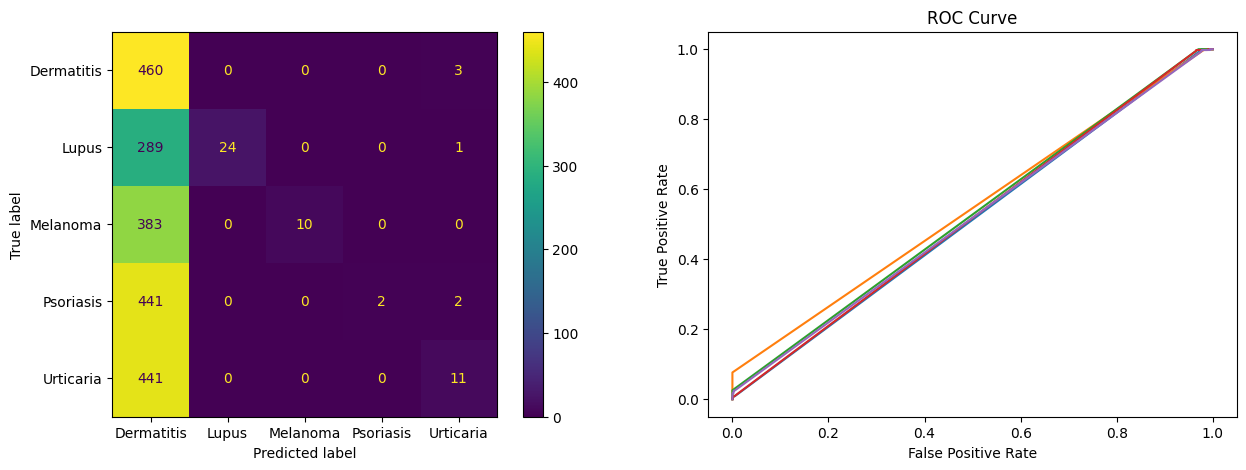

In [56]:
best_params = grid_search_lr(X_train_ngram_proc)
model_lr(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "ngram")

**TF-IDF**

100%|██████████| 50/50 [00:12<00:00,  4.06trial/s, best loss: -0.748396561599554] 
Best hyperparameters: {'C': 5.502542578284573, 'max_iter': 200, 'penalty': 'l2', 'solver': 'saga'}
Training Results
Accuracy Score: 0.8043
Specificity Score: 0.8043
Precision Score: 0.8058
F1 Score: 0.8038

Testing Results
Accuracy Score: 0.7213
Specificity Score: 0.7213
Precision Score: 0.7229
F1 Score: 0.7212

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.70      0.69      0.70      1803
       Lupus       0.89      0.90      0.89      1355
    Melanoma       0.99      0.99      0.99      1677
   Psoriasis       0.77      0.67      0.72      1668
   Urticaria       0.70      0.79      0.75      1764

    accuracy                           0.80      8267
   macro avg       0.81      0.81      0.81      8267
weighted avg       0.81      0.80      0.80      8267


Classification Report Test
              precision    recall  f1-score   support

  D

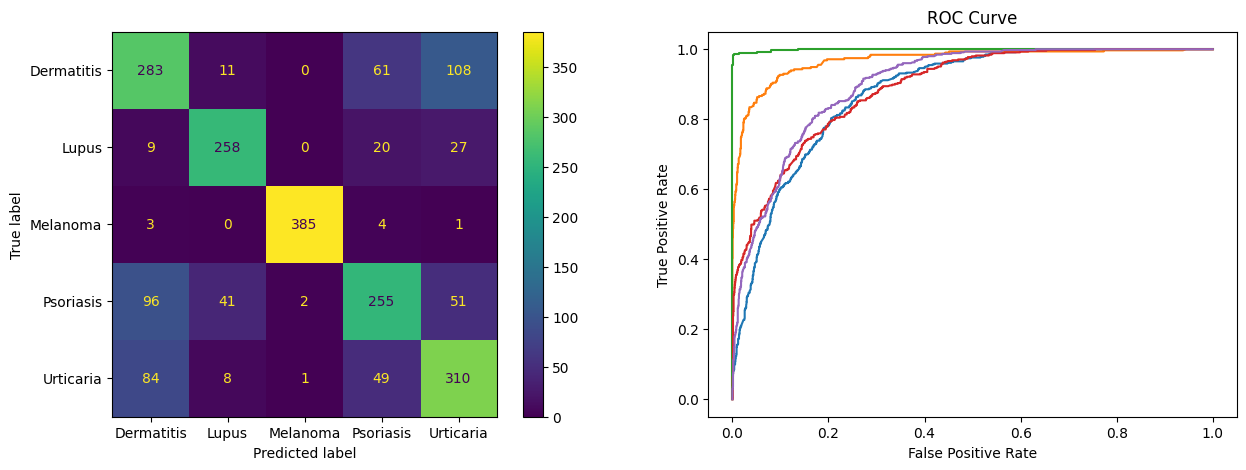

In [57]:
best_params = hyperopt_lr(X_train_tfidf_proc)
model_lr(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

Best parameters: {'C': 1.0, 'max_iter': 50, 'penalty': 'l2', 'solver': 'lbfgs'}
Training Results
Accuracy Score: 0.7887
Specificity Score: 0.7887
Precision Score: 0.7921
F1 Score: 0.7887

Testing Results
Accuracy Score: 0.7286
Specificity Score: 0.7286
Precision Score: 0.7315
F1 Score: 0.7286

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.69      0.69      0.69      1803
       Lupus       0.88      0.86      0.87      1355
    Melanoma       0.99      0.98      0.99      1677
   Psoriasis       0.75      0.64      0.69      1668
   Urticaria       0.68      0.79      0.73      1764

    accuracy                           0.79      8267
   macro avg       0.80      0.79      0.79      8267
weighted avg       0.79      0.79      0.79      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.60      0.62      0.61       463
       Lupus       0.81      0.81      0.81       3

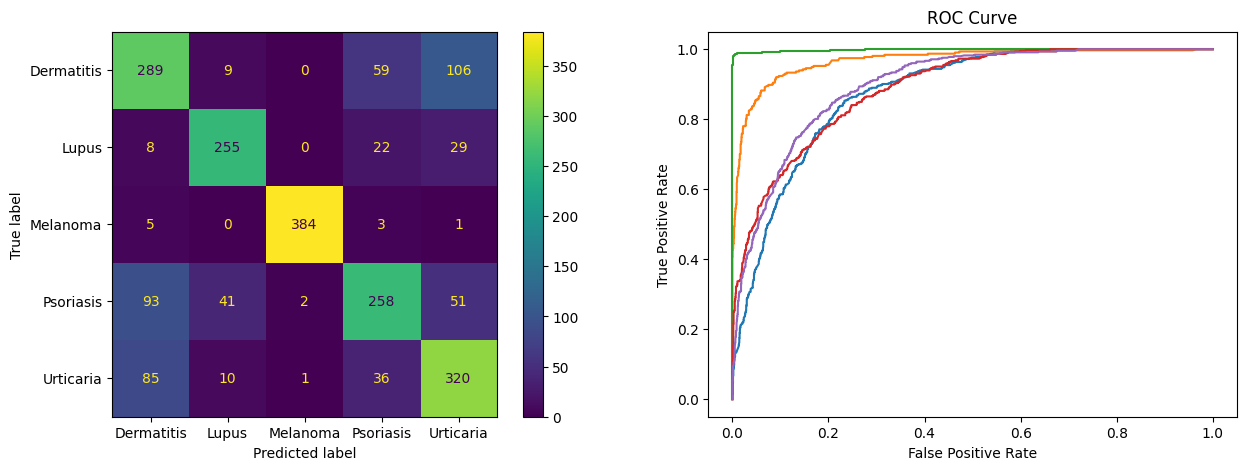

In [58]:
best_params = grid_search_lr(X_train_tfidf_proc)
model_lr(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

##### With lamatization

In [59]:
name = "LR_lem_"

**BoW** 

100%|██████████| 50/50 [00:10<00:00,  4.89trial/s, best loss: -0.826901438226346] 
Best hyperparameters: {'C': 6.517918968441976, 'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.8680
Specificity Score: 0.8680
Precision Score: 0.8743
F1 Score: 0.8686

Testing Results
Accuracy Score: 0.8355
Specificity Score: 0.8355
Precision Score: 0.8412
F1 Score: 0.8360

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.74      0.88      0.80      1803
       Lupus       0.89      0.92      0.91      1355
    Melanoma       0.99      0.97      0.98      1677
   Psoriasis       0.84      0.74      0.78      1668
   Urticaria       0.93      0.84      0.88      1764

    accuracy                           0.87      8267
   macro avg       0.88      0.87      0.87      8267
weighted avg       0.87      0.87      0.87      8267


Classification Report Test
              precision    recall  f1-score   support


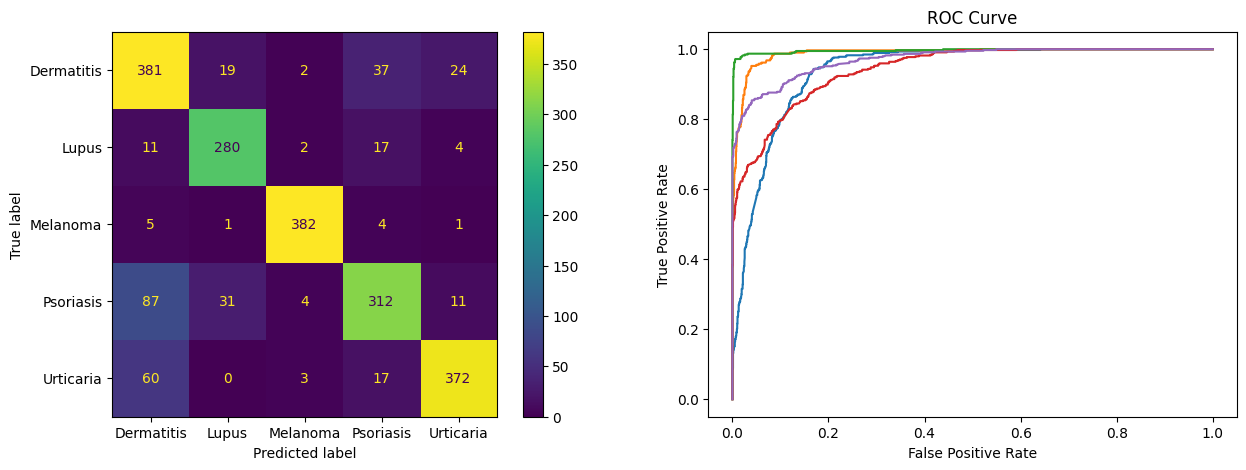

In [60]:
best_params = hyperopt_lr(X_train_bow_lem)
model_lr(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

Best parameters: {'C': 4.0, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.8692
Specificity Score: 0.8692
Precision Score: 0.8757
F1 Score: 0.8699

Testing Results
Accuracy Score: 0.8312
Specificity Score: 0.8312
Precision Score: 0.8374
F1 Score: 0.8318

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.74      0.88      0.80      1803
       Lupus       0.90      0.92      0.91      1355
    Melanoma       0.99      0.97      0.98      1677
   Psoriasis       0.84      0.74      0.78      1668
   Urticaria       0.93      0.84      0.89      1764

    accuracy                           0.87      8267
   macro avg       0.88      0.87      0.87      8267
weighted avg       0.88      0.87      0.87      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.69      0.82      0.75       463
       Lupus       0.85      0.89      0.87   

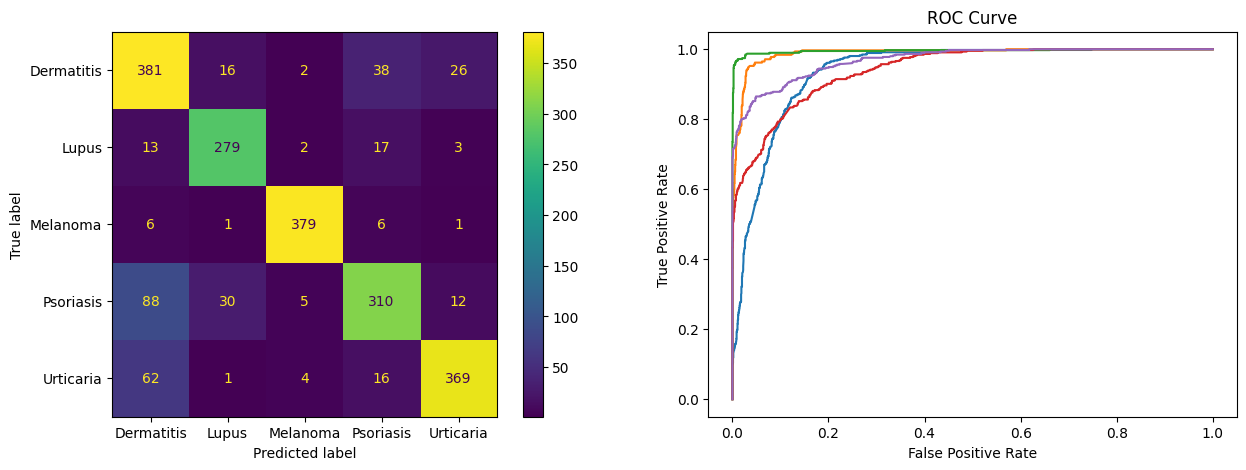

In [61]:
best_params = grid_search_lr(X_train_bow_lem)
model_lr(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

**n-grams**

100%|██████████| 50/50 [00:46<00:00,  1.07trial/s, best loss: -0.2881331147574561] 
Best hyperparameters: {'C': 9.124465627367123, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.3438
Specificity Score: 0.3438
Precision Score: 0.8222
F1 Score: 0.3007

Testing Results
Accuracy Score: 0.2980
Specificity Score: 0.2980
Precision Score: 0.7691
F1 Score: 0.2194

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.25      0.99      0.40      1803
       Lupus       1.00      0.28      0.44      1355
    Melanoma       1.00      0.09      0.16      1677
   Psoriasis       0.99      0.17      0.29      1668
   Urticaria       0.95      0.13      0.24      1764

    accuracy                           0.34      8267
   macro avg       0.84      0.33      0.31      8267
weighted avg       0.82      0.34      0.30      8267


Classification Report Test
              precision    recall  f1-score   suppor

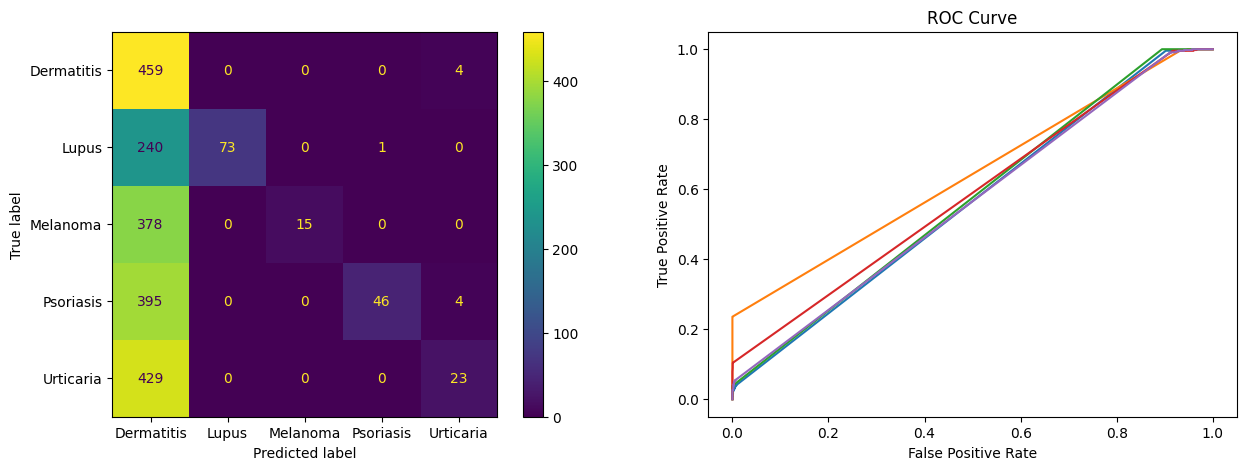

In [62]:
best_params = hyperopt_lr(X_train_ngram_lem)
model_lr(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "ngram")

Best parameters: {'C': 2.0, 'max_iter': 20, 'penalty': 'l1', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.3434
Specificity Score: 0.3434
Precision Score: 0.8186
F1 Score: 0.3006

Testing Results
Accuracy Score: 0.2966
Specificity Score: 0.2966
Precision Score: 0.7756
F1 Score: 0.2166

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.25      0.99      0.40      1803
       Lupus       1.00      0.28      0.44      1355
    Melanoma       1.00      0.09      0.16      1677
   Psoriasis       0.97      0.17      0.29      1668
   Urticaria       0.94      0.13      0.24      1764

    accuracy                           0.34      8267
   macro avg       0.83      0.33      0.31      8267
weighted avg       0.82      0.34      0.30      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.24      0.99      0.39       463
       Lupus       1.00      0.23      0.38    

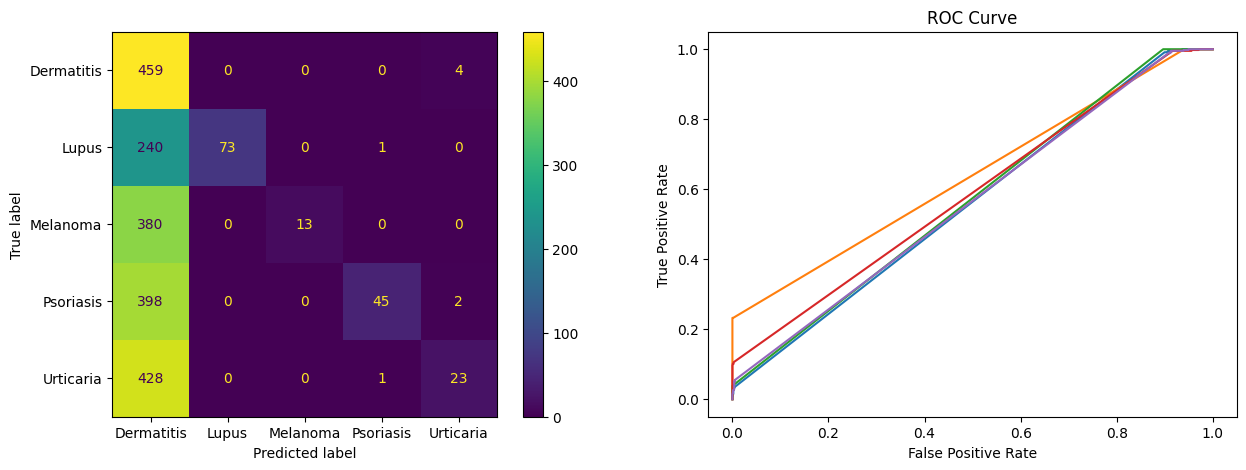

In [63]:
best_params = grid_search_lr(X_train_bow_lem)
model_lr(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "ngram")

**TF-IDF**

100%|██████████| 50/50 [00:09<00:00,  5.23trial/s, best loss: -0.8305309828379898]
Best hyperparameters: {'C': 2.7104712026122075, 'max_iter': 5, 'penalty': 'l2', 'solver': 'newton-cg'}
Training Results
Accuracy Score: 0.8734
Specificity Score: 0.8734
Precision Score: 0.8765
F1 Score: 0.8737

Testing Results
Accuracy Score: 0.8239
Specificity Score: 0.8239
Precision Score: 0.8294
F1 Score: 0.8247

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.76      0.86      0.80      1803
       Lupus       0.90      0.93      0.91      1355
    Melanoma       0.98      0.97      0.98      1677
   Psoriasis       0.83      0.76      0.79      1668
   Urticaria       0.92      0.87      0.89      1764

    accuracy                           0.87      8267
   macro avg       0.88      0.88      0.88      8267
weighted avg       0.88      0.87      0.87      8267


Classification Report Test
              precision    recall  f1-score   support


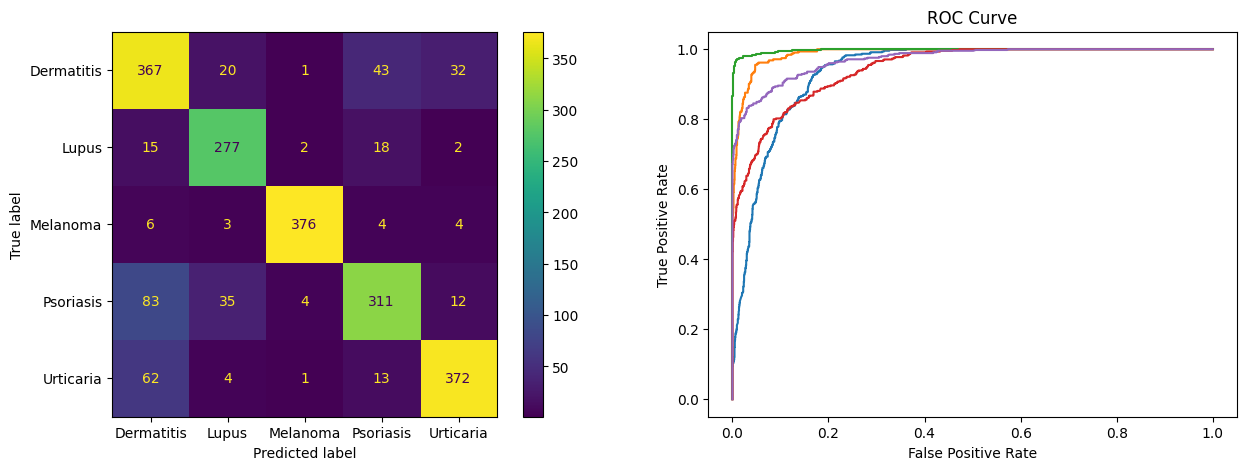

In [64]:
best_params = hyperopt_lr(X_train_tfidf_lem)
model_lr(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

Best parameters: {'C': 4.0, 'max_iter': 20, 'penalty': 'l2', 'solver': 'sag'}
Training Results
Accuracy Score: 0.8778
Specificity Score: 0.8778
Precision Score: 0.8809
F1 Score: 0.8782

Testing Results
Accuracy Score: 0.8258
Specificity Score: 0.8258
Precision Score: 0.8310
F1 Score: 0.8268

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.77      0.86      0.81      1803
       Lupus       0.91      0.93      0.92      1355
    Melanoma       0.98      0.97      0.98      1677
   Psoriasis       0.83      0.77      0.80      1668
   Urticaria       0.92      0.87      0.90      1764

    accuracy                           0.88      8267
   macro avg       0.88      0.88      0.88      8267
weighted avg       0.88      0.88      0.88      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.69      0.79      0.74       463
       Lupus       0.84      0.87      0.85       314

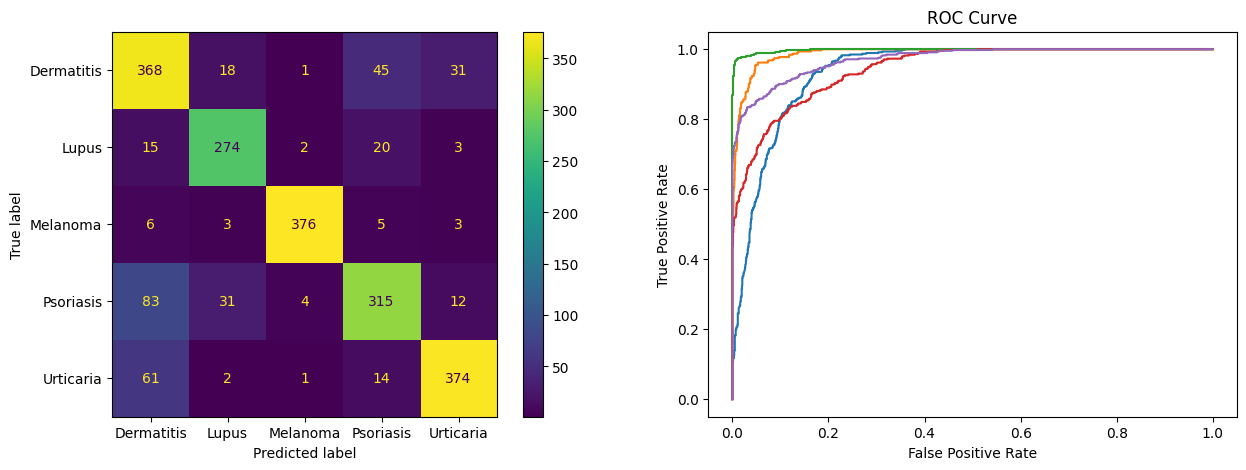

In [65]:
best_params = grid_search_lr(X_train_tfidf_lem)
model_lr(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

##### With stemming

In [66]:
name = "LR_stem_"

**BoW** 

100%|██████████| 50/50 [00:21<00:00,  2.31trial/s, best loss: -0.8725047932343891]
Best hyperparameters: {'C': 1.0931068756723452, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.9219
Specificity Score: 0.9219
Precision Score: 0.9241
F1 Score: 0.9222

Testing Results
Accuracy Score: 0.8718
Specificity Score: 0.8718
Precision Score: 0.8761
F1 Score: 0.8723

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.83      0.91      0.87      1803
       Lupus       0.96      0.97      0.96      1355
    Melanoma       0.99      0.98      0.99      1677
   Psoriasis       0.90      0.84      0.87      1668
   Urticaria       0.95      0.91      0.93      1764

    accuracy                           0.92      8267
   macro avg       0.93      0.92      0.92      8267
weighted avg       0.92      0.92      0.92      8267


Classification Report Test
              precision    recall  f1-score   suppor

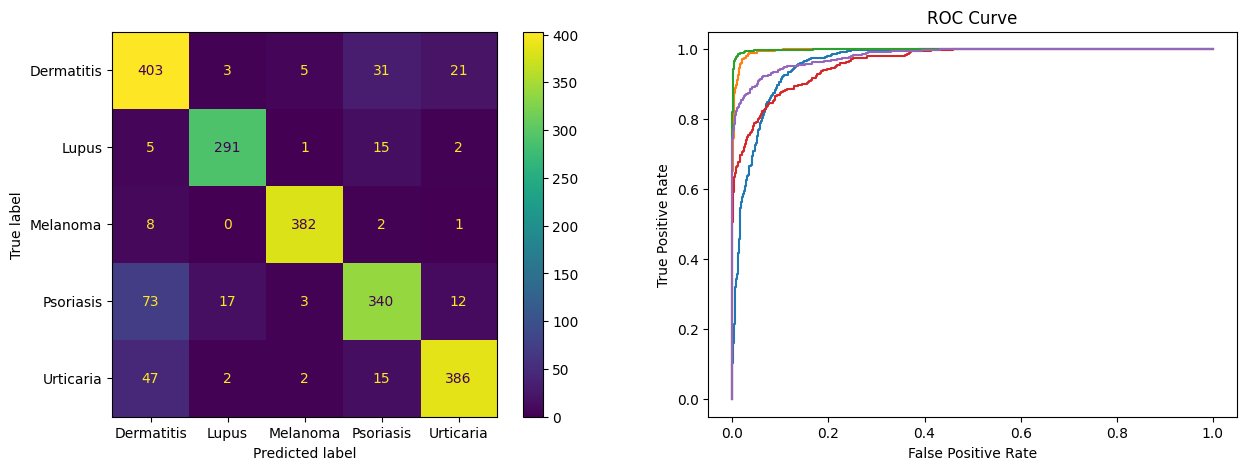

In [67]:
best_params = hyperopt_lr(X_train_bow_stem)
model_lr(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

Best parameters: {'C': 1.0, 'max_iter': 5, 'penalty': 'l2', 'solver': 'newton-cg'}
Training Results
Accuracy Score: 0.9265
Specificity Score: 0.9265
Precision Score: 0.9285
F1 Score: 0.9268

Testing Results
Accuracy Score: 0.8708
Specificity Score: 0.8708
Precision Score: 0.8752
F1 Score: 0.8716

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.84      0.92      0.87      1803
       Lupus       0.96      0.97      0.97      1355
    Melanoma       0.99      0.98      0.99      1677
   Psoriasis       0.91      0.86      0.88      1668
   Urticaria       0.95      0.91      0.93      1764

    accuracy                           0.93      8267
   macro avg       0.93      0.93      0.93      8267
weighted avg       0.93      0.93      0.93      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.75      0.86      0.80       463
       Lupus       0.94      0.92      0.93     

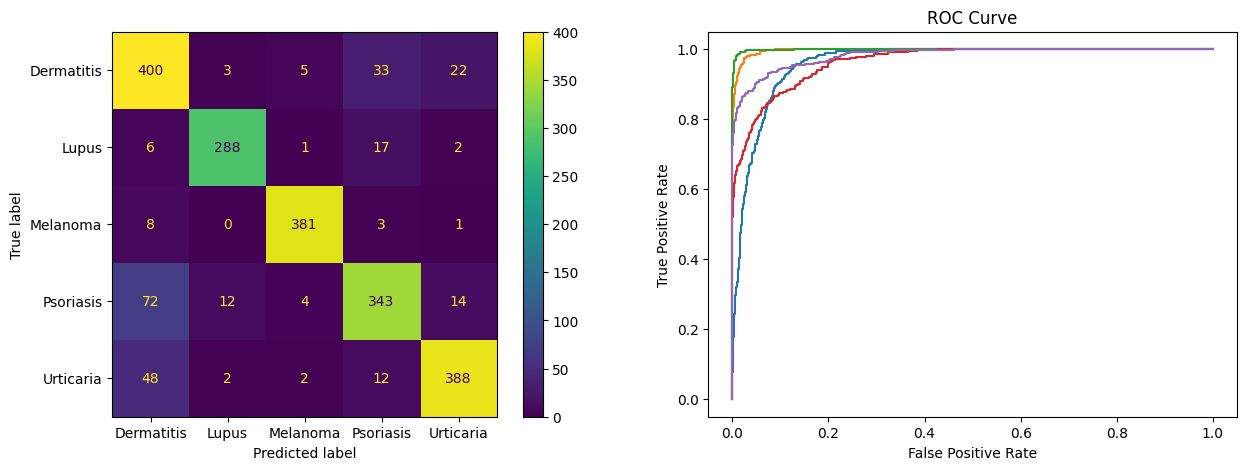

In [68]:
best_params = grid_search_lr(X_train_bow_stem)
model_lr(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

**n-grams**

100%|██████████| 50/50 [01:07<00:00,  1.36s/trial, best loss: -0.555099628318597]
Best hyperparameters: {'C': 7.771625584259131, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.9963
Specificity Score: 0.9963
Precision Score: 0.9963
F1 Score: 0.9963

Testing Results
Accuracy Score: 0.5631
Specificity Score: 0.5631
Precision Score: 0.7460
F1 Score: 0.5864

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.99      1.00      0.99      1803
       Lupus       1.00      1.00      1.00      1355
    Melanoma       1.00      1.00      1.00      1677
   Psoriasis       1.00      0.99      1.00      1668
   Urticaria       1.00      1.00      1.00      1764

    accuracy                           1.00      8267
   macro avg       1.00      1.00      1.00      8267
weighted avg       1.00      1.00      1.00      8267


Classification Report Test
              precision    recall  f1-score   support


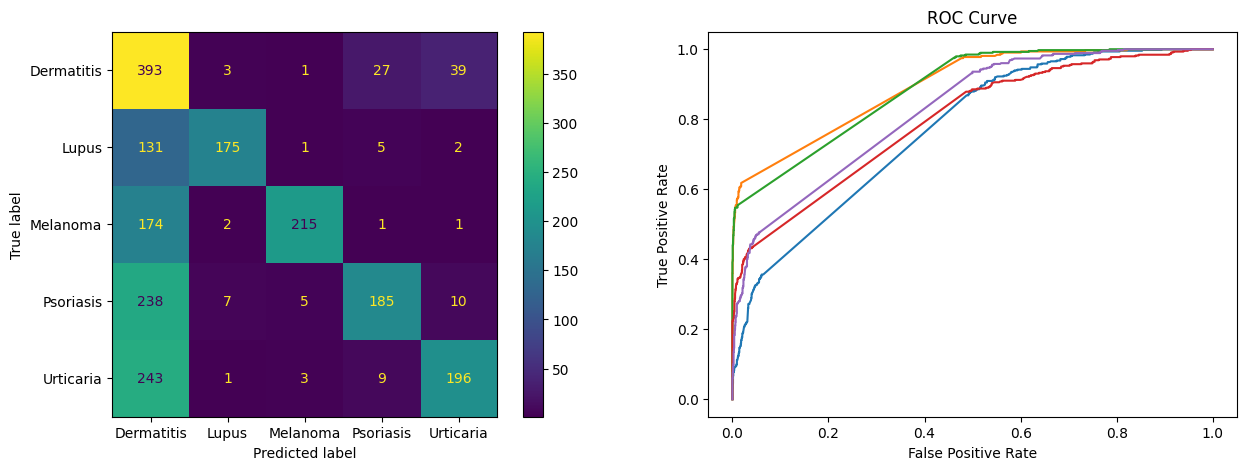

In [69]:
best_params = hyperopt_lr(X_train_ngram_stem)
model_lr(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "ngram")

Best parameters: {'C': 7.0, 'max_iter': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Training Results
Accuracy Score: 0.9819
Specificity Score: 0.9819
Precision Score: 0.9821
F1 Score: 0.9819

Testing Results
Accuracy Score: 0.5656
Specificity Score: 0.5656
Precision Score: 0.7392
F1 Score: 0.5883

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.97      0.97      0.97      1803
       Lupus       1.00      0.99      0.99      1355
    Melanoma       1.00      0.99      1.00      1677
   Psoriasis       0.99      0.98      0.99      1668
   Urticaria       0.95      0.99      0.97      1764

    accuracy                           0.98      8267
   macro avg       0.98      0.98      0.98      8267
weighted avg       0.98      0.98      0.98      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.34      0.84      0.48       463
       Lupus       0.91      0.58      0.71       3

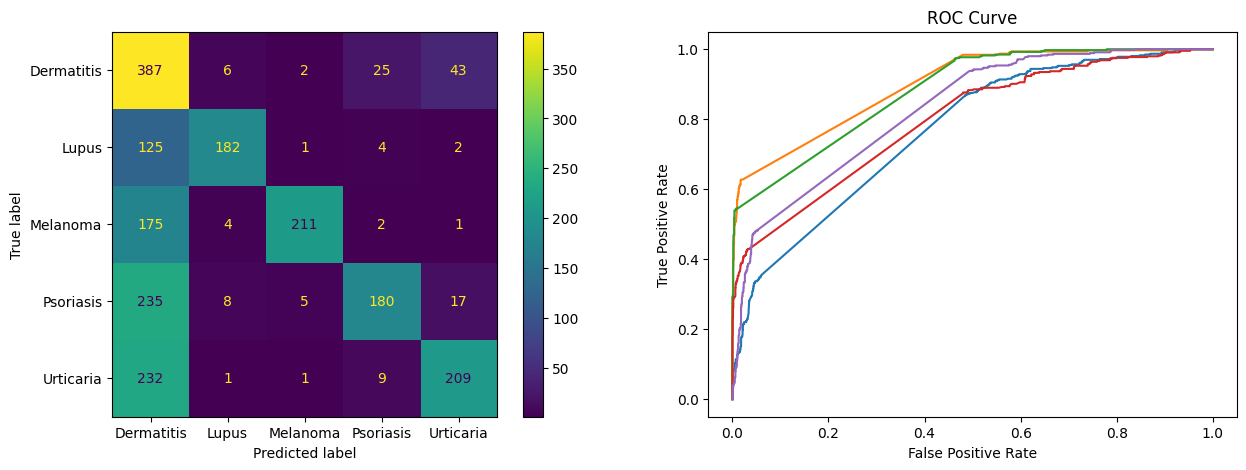

In [70]:
best_params = grid_search_lr(X_train_ngram_stem)
model_lr(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "ngram")

**TF-IDF**

100%|██████████| 50/50 [00:10<00:00,  4.80trial/s, best loss: -0.8774654707903478]
Best hyperparameters: {'C': 3.7792144085661312, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.9286
Specificity Score: 0.9286
Precision Score: 0.9306
F1 Score: 0.9289

Testing Results
Accuracy Score: 0.8713
Specificity Score: 0.8713
Precision Score: 0.8744
F1 Score: 0.8717

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.84      0.92      0.88      1803
       Lupus       0.96      0.97      0.97      1355
    Melanoma       0.99      0.98      0.99      1677
   Psoriasis       0.92      0.85      0.89      1668
   Urticaria       0.95      0.92      0.94      1764

    accuracy                           0.93      8267
   macro avg       0.93      0.93      0.93      8267
weighted avg       0.93      0.93      0.93      8267


Classification Report Test
              precision    recall  f1-score   suppor

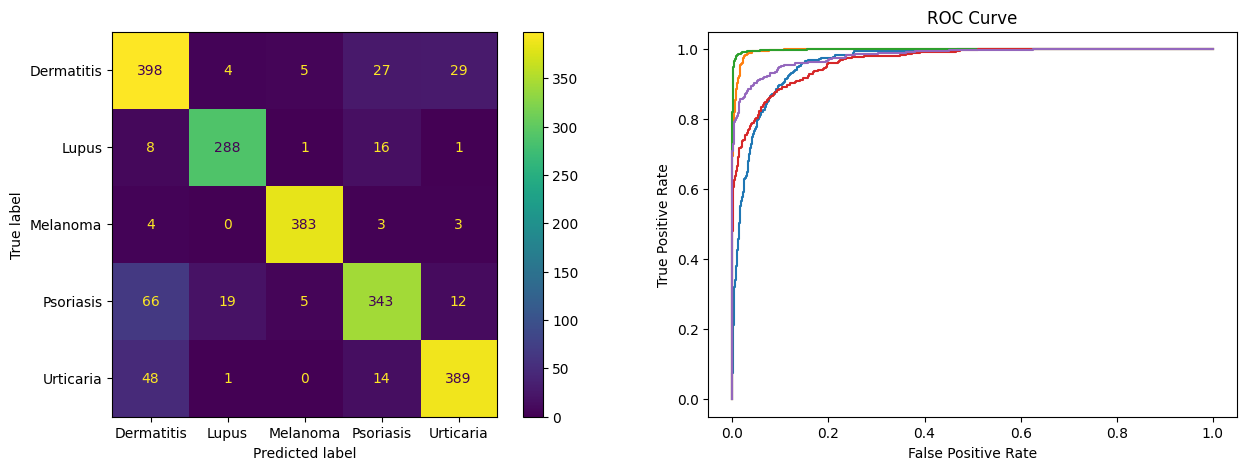

In [71]:
best_params = hyperopt_lr(X_train_tfidf_stem)
model_lr(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

Best parameters: {'C': 3.0, 'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Training Results
Accuracy Score: 0.9257
Specificity Score: 0.9257
Precision Score: 0.9277
F1 Score: 0.9260

Testing Results
Accuracy Score: 0.8728
Specificity Score: 0.8728
Precision Score: 0.8761
F1 Score: 0.8731

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.84      0.92      0.88      1803
       Lupus       0.96      0.97      0.96      1355
    Melanoma       0.99      0.98      0.99      1677
   Psoriasis       0.91      0.85      0.88      1668
   Urticaria       0.95      0.91      0.93      1764

    accuracy                           0.93      8267
   macro avg       0.93      0.93      0.93      8267
weighted avg       0.93      0.93      0.93      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.76      0.86      0.81       463
       Lupus       0.92      0.92      0.92    

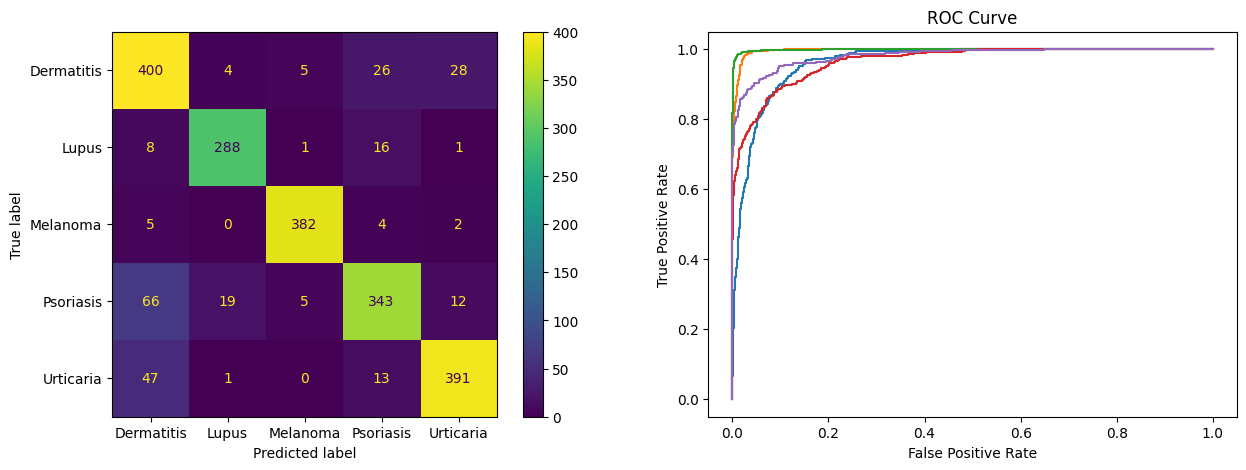

In [72]:
best_params = grid_search_lr(X_train_tfidf_stem)
model_lr(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

##### Save best model

In [73]:
joblib.dump(best_model,f'Models/LR/{best_modeltype_lr}.pkl')
print(best_score_lr)

0.8731478637702893


#### Naive Bayes

**Important Parameters:**
- Alpha
- Fit Prior
- Class Prior

In [103]:
best_score_nb = 0
best_modeltype_nb = ""
best_model = None

##### Hyperopt ####

In [104]:
def hyperopt_nb(X_train):
    space = {
        'alpha': hp.uniform('alpha', 0.0, 2.0),
        'fit_prior': hp.choice('fit_prior', [True, False]),
        'class_prior': hp.choice('class_prior', [None, hp.uniform('class_prior_uniform',0.0,1.0)])
    }

    def objective(params):
        clf = MultinomialNB(alpha=params['alpha'], fit_prior=params['fit_prior'], class_prior=params['class_prior'])
        score = cross_val_score(clf, X_train.toarray(), y_train, cv=5).mean()
        return -score

    tpe_algorithm = tpe.suggest

    trials = Trials()

    best = fmin(fn=objective,
            space=space,
            algo=tpe_algorithm,
            max_evals=50,
            trials=trials)

    best_params = space_eval(space, best)
    print("Best hyperparameters:", best_params)
    return best_params

##### Grid Search

In [105]:
def grid_search_nb(X_train):
    nb = MultinomialNB()

    param_grid = {
        'alpha': [0.0, 0.1, 0.5, 1.0, 2.0],
        'fit_prior': [True, False],
        'class_prior': [None, [0.1, 0.9],[0.2, 0.8],[0.3, 0.7],[0.4, 0.6]]
    }

    gs_nb = GridSearchCV(estimator=nb, param_grid=param_grid, verbose=0, n_jobs=-1, cv=2, scoring='accuracy')
    gs_nb.fit(X_train.toarray(), y_train)

    print(f"Best parameters: {gs_nb.best_params_}")
    return gs_nb.best_params_

##### Run Model

In [106]:
def model_nb(best_param, X_train, X_test, model_type, y_train, y_test):

    global best_score_nb, best_modeltype_nb, best_model

    nb = MultinomialNB(alpha=best_param['alpha'], fit_prior=best_param['fit_prior'], class_prior=best_param['class_prior'])
    nb.fit(X_train, y_train)
    score = evaluate(nb, X_train, X_test, y_train, y_test)
    if score > best_score_nb:
        best_score_nb = score
        best_modeltype_nb = model_type
        best_model = nb

##### Without Preprocessing

In [107]:
name = "NB_withoutyproc_"

**BoW** 

In [108]:
best_params = hyperopt_nb(X_train_bow_noproc)
model_nb(best_params, X_train_bow_noproc, X_test_bow_noproc , name + "bow")

  2%|▏         | 1/50 [00:01<00:58,  1.19s/trial, best loss: -0.707633477221804]

job exception: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mafs6\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mafs6\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\mafs6\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\mafs6\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, 

  2%|▏         | 1/50 [00:01<01:04,  1.31s/trial, best loss: -0.707633477221804]


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mafs6\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mafs6\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\mafs6\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\mafs6\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'class_prior' parameter of MultinomialNB must be an array-like or None. Got 0.7266211112845238 instead.


In [ ]:
best_params = grid_search_nb(X_train_bow_noproc)
model_nb(best_params, X_train_bow_noproc, X_test_bow_noproc, name + "bow")

**n-grams**

In [ ]:
best_params = hyperopt_nb(X_train_ngram_noproc)
model_nb(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "ngram")

In [ ]:
best_params = grid_search_nb(X_train_ngram_noproc)
model_nb(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_nb(X_train_tfidf_noproc)
model_nb(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

In [ ]:
best_params = grid_search_nb(X_train_tfidf_noproc)
model_nb(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

##### With Preprocessing

In [ ]:
name = "NB_withproc_"

**BoW** 

In [ ]:
best_params = hyperopt_nb(X_train_bow_proc)
model_nb(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

In [ ]:
best_params = grid_search_nb(X_train_bow_proc,y_train)
model_nb(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

**n-grams**

In [ ]:
best_params = hyperopt_nb(X_train_ngram_proc)
model_nb(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "ngram")

In [ ]:
best_params = grid_search_nb(X_train_ngram_proc,y_train)
model_nb(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_nb(X_train_tfidf_proc)
model_nb(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

In [ ]:
best_params = grid_search_nb(X_train_tfidf_proc,y_train)
model_nb(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

##### With lamatization

In [ ]:
name = "NB_lem_"

**BoW** 

In [ ]:
best_params = hyperopt_nb(X_train_bow_lem)
model_nb(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

In [ ]:
best_params = grid_search_nb(X_train_bow_lem)
model_nb(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

**n-grams**

In [ ]:
best_params = hyperopt_nb(X_train_ngram_lem)
model_nb(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "ngram")

In [ ]:
best_params = grid_search_nb(X_train_bow_lem)
model_nb(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_nb(X_train_tfidf_lem)
model_nb(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

In [ ]:
best_params = grid_search_nb(X_train_tfidf_lem)
model_nb(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

##### Witth stemming

In [ ]:
name = "NB_stem_"

**BoW** 

In [ ]:
best_params = hyperopt_nb(X_train_bow_stem)
model_nb(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

In [ ]:
best_params = grid_search_nb(X_train_bow_stem)
model_nb(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

**n-grams**

In [ ]:
best_params = hyperopt_nb(X_train_ngram_stem)
model_nb(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "ngram")

In [ ]:
best_params = grid_search_nb(X_train_ngram_stem)
model_nb(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_nb(X_train_tfidf_stem)
model_nb(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

In [ ]:
best_params = grid_search_nb(X_train_tfidf_stem)
model_nb(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

##### Save best model

In [ ]:
joblib.dump(best_model,f'Models/NB/{best_modeltype_nb}.pkl')
print(best_score_nb)

#### Support Vector Machinne

**Important Parameters:**
- Kernel
- Gamma
- C

In [ ]:
best_score_svm = 0
best_modeltype_svm = ""
best_model = None

##### Hyperopt #####

In [ ]:
def hyperopt_svm(X_train):
    space = {
        'C': hp.choice('C', [0.1, 1, 10, 100, 1000]),
        'gamma': hp.choice('gamma', [1, 0.1, 0.01, 0.001, 0.0001]),
        'kernel': hp.choice('kernel', ['rbf', 'linear'])
    }

    def objective(params):
        clf = SVC(C=1, gamma=params['gamma'], kernel=params['kernel'])
        score = cross_val_score(clf, X_train.toarray(), y_train, cv=5).mean()
        return -score 

    tpe_algorithm = tpe.suggest

    trials = Trials()

    best = fmin(fn=objective,
            space=space,
            algo=tpe_algorithm,
            max_evals=50,
            trials=trials)

    best_params = space_eval(space, best)
    print("Best hyperparameters:", best_params)
    return best_params

##### Grid Search

In [ ]:
def grid_search_svm(X_train):
    svm = SVC()

    param_grid = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf', 'linear']
    }

    gs_svm = GridSearchCV(estimator=svm, param_grid=param_grid, verbose=0, n_jobs=-1, cv=2, scoring='accuracy')
    gs_svm.fit(X_train.toarray(), y_train)

    print(f"Best parameters: {gs_svm.best_params_}")
    return gs_svm.best_params_


##### Run Model

In [ ]:
def model_svm(best_param, X_train, X_test, model_type):

    global best_score_svm, best_modeltype_svm, best_model

    svm = SVC(C=best_param['C'], gamma = best_param['gamma'], kernel=best_param['rbf'])
    svm.fit(X_train, y_train)
    score = evaluate(svm, X_train, X_test, y_train, y_test)
    if score > best_score_svm:
        best_score_svm = score
        best_modeltype_svm = model_type
        best_model = svm

##### Without Preprocessing

In [ ]:
name = "SVM_withoutyproc_"

**BoW** 

In [ ]:
best_params = hyperopt_svm(X_train_bow_noproc)
model_svm(best_params, X_train_bow_noproc, X_test_bow_noproc , name + "bow")

In [ ]:
best_params = grid_search_svm(X_train_bow_noproc)
model_svm(best_params, X_train_bow_noproc, X_test_bow_noproc, name + "bow")

**n-grams**

In [ ]:
best_params = hyperopt_svm(X_train_ngram_noproc)
model_svm(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "ngram")

In [ ]:
best_params = grid_search_svm(X_train_ngram_noproc)
model_svm(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_svm(X_train_tfidf_noproc)
model_svm(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

In [ ]:
best_params = grid_search_svm(X_train_tfidf_noproc)
model_svm(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

##### With Preprocessing

In [ ]:
name = "SVM_withproc_"

**BoW** 

In [ ]:
best_params = hyperopt_svm(X_train_bow_proc)
model_svm(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

In [ ]:
best_params = grid_search_svm(X_train_bow_proc,y_train)
model_svm(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

**n-grams**

In [ ]:
best_params = hyperopt_svm(X_train_ngram_proc)
model_svm(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "ngram")

In [ ]:
best_params = grid_search_svm(X_train_ngram_proc,y_train)
model_svm(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_svm(X_train_tfidf_proc)
model_svm(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

In [ ]:
best_params = grid_search_svm(X_train_tfidf_proc,y_train)
model_svm(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

##### With lamatization

In [ ]:
name = "SVM_lem_"

**BoW** 

In [ ]:
best_params = hyperopt_svm(X_train_bow_lem)
model_svm(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

In [ ]:
best_params = grid_search_svm(X_train_bow_lem)
model_svm(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

**n-grams**

In [ ]:
best_params = hyperopt_svm(X_train_ngram_lem)
model_svm(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "ngram")

In [ ]:
best_params = grid_search_svm(X_train_bow_lem)
model_svm(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_svm(X_train_tfidf_lem)
model_svm(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

In [ ]:
best_params = grid_search_svm(X_train_tfidf_lem)
model_svm(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

##### Witth stemming

In [ ]:
name = "SVM_stem_"

**BoW** 

In [ ]:
best_params = hyperopt_svm(X_train_bow_stem)
model_svm(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

In [ ]:
best_params = grid_search_svm(X_train_bow_stem)
model_svm(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

**n-grams**

In [ ]:
best_params = hyperopt_svm(X_train_ngram_stem)
model_svm(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "ngram")

In [ ]:
best_params = grid_search_svm(X_train_ngram_stem)
model_svm(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_svm(X_train_tfidf_stem)
model_svm(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

In [ ]:
best_params = grid_search_svm(X_train_tfidf_stem)
model_svm(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

##### Save best model

In [ ]:
joblib.dump(best_model,f'Models/SVM/{best_modeltype_svm}.pkl')
print(best_score_svm)

### Deep Learning

In [ ]:
# Define number of unique words
words = set()

#### Recurrent Neural Network

In [ ]:
# Create RNN model for text classification
vocab_size = 5000
embedding_dim = 32

rnn = Sequential(name="Basic_RNN")
rnn.add(Embedding(vocab_size, embedding_dim))
rnn.add(SimpleRNN(128, activation='relu', return_sequences= True))
rnn.add(SimpleRNN(64, activation='relu', return_sequences= True))
rnn.add(SimpleRNN(32, activation='relu'))
rnn.add(Dense(4, activation='softmax'))

rnn.build(input_shape=(None, X_train.shape[1]))

print(rnn.summary())

rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#history = rnn.fit(X_train.toarray(), y_train, epochs=10, validation_data=(X_test.toarray(), y_test))

#### Conv 1D

In [ ]:
# Create Conv1D model for text classification
conv1d = Sequential(name="Conv1D")
conv1d.add(Embedding(vocab_size, embedding_dim))
conv1d.add(Conv1D(128, 5, activation='relu'))
conv1d.add(GlobalMaxPooling1D())
conv1d.add(Dense(64, activation='relu'))
conv1d.add(Dense(4, activation='softmax'))

conv1d.build(input_shape=(None, X_train.shape[1]))

print(conv1d.summary())

#### LSTM

In [ ]:
# Create LSTM model for text classification
lstm = Sequential(name="LSTM")
lstm.add(Embedding(vocab_size, embedding_dim))
lstm.add(LSTM(32))
lstm.add(Dropout(0.4))
lstm.add(Dense(4, activation='softmax'))

lstm.build(input_shape=(None, X_train.shape[1]))

print(lstm.summary())

#### BILSTM

In [ ]:
# Create LSTM model for text classification
blstm = Sequential(name="Bi_LSTM")
blstm.add(Embedding(vocab_size, embedding_dim))
blstm.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1))))
blstm.add(Dropout(0.4))
blstm.add(Bidirectional(LSTM(32)))
blstm.add(Dropout(0.2))
blstm.add(Dense(64, activation='relu'))
blstm.add(Dropout(0.1))
blstm.add(Dense(4, activation='softmax'))

blstm.build(input_shape=(None, X_train.shape[1]))

print(blstm.summary())
